# Full train GRU indicator(GRU4 based)

## **IMPORTANT** The model return 25 times the predict value, this is due to data scaling

In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
df_prices = pd.read_pickle("df_prices.pkl")
df_returns = pd.read_pickle("df_returns.pkl")
data = pd.read_pickle("data.pkl") 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1181900 entries, ('A', Timestamp('2014-09-17 00:00:00')) to ('^GSPC', Timestamp('2024-04-29 00:00:00'))
Data columns (total 29 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Dollar_Volume  1181900 non-null  float64
 1   RSI            1181900 non-null  float64
 2   BB_High        1181900 non-null  float64
 3   BB_Mid         1181900 non-null  float64
 4   BB_Low         1181900 non-null  float64
 5   ATR            1181900 non-null  float64
 6   NATR           1181900 non-null  float64
 7   MACD           1181900 non-null  float64
 8   Return_1d      1181900 non-null  float64
 9   Return_5d      1181900 non-null  float64
 10  Return_10d     1181900 non-null  float64
 11  Return_21d     1181900 non-null  float64
 12  Return_42d     1181900 non-null  float64
 13  Return_63d     1181900 non-null  float64
 14  High_Return    1181900 non-null  float64
 15  Low_Return     1181900 non

In [5]:
data

Dollar_Volume        RSI   BB_High    BB_Mid    BB_Low  \
Ticker Date                                                                 
A      2014-09-17   1.470448e+02  61.678030  3.680738  3.666559  3.652380   
       2014-09-18   1.542749e+02  56.728376  3.680943  3.666618  3.652292   
       2014-09-19   1.166837e+02  55.266087  3.681442  3.666836  3.652229   
       2014-09-22   8.943596e+01  48.928179  3.681454  3.666759  3.652065   
       2014-09-23   8.569924e+01  44.457218  3.682135  3.666114  3.650093   
...                          ...        ...       ...       ...       ...   
^GSPC  2024-04-23   1.902166e+07  45.672800  8.580116  8.544940  8.509764   
       2024-04-24   1.854563e+07  45.804452  8.578809  8.543656  8.508503   
       2024-04-25   1.998190e+07  43.372114  8.576022  8.541713  8.507404   
       2024-04-26   1.838097e+07  49.753005  8.572539  8.540222  8.507905   
       2024-04-29   1.763774e+07  51.600215  8.569251  8.538991  8.508731   

                        ATR      NATR      MACD  Return_1d  Return_5d  ...  \
Ticker Date                                                            ...   
A      2014-09-17 -0.057416  9.082803 -0.031031   0.016923   0.004126  ...   
       2014-09-18 -0.038734  9.186808 -0.027924  -0.008320   0.002797  ...   
       2014-09-19 -0.018577  9.240536 -0.032016  -0.002569  -0.001197  ...   
       2014-09-22 -0.058006  9.293398 -0.059349  -0.012017  -0.001281  ...   
       2014-09-23 -0.100418  9.321688 -0.100407  -0.009905  -0.003233  ...   
...                     ...       ...       ...        ...        ...  ...   
^GSPC  2024-04-23  0.889211  1.177138 -1.181411   0.011965   0.000757  ...   
       2024-04-24  0.837421  1.152624 -1.122103   0.000213   0.001960  ...   
       2024-04-25  0.905340  1.189890 -1.117749  -0.004576   0.001484  ...   
       2024-04-26  0.923767  1.186450 -0.989023   0.010209   0.005288  ...   
       2024-04-29  0.846604  1.146854 -0.843479   0.003178   0.004179  ...   

                   Momentum_5_10  Momentum_21  Momentum_5_21  Momentum_42  \
Ticker Date                                                                 
A      2014-09-17      -0.002706    -0.016623      -0.003826    -0.015788   
       2014-09-18      -0.001573     0.008190      -0.002928     0.009020   
       2014-09-19       0.001766     0.002503       0.001132     0.002786   
       2014-09-22       0.001107     0.011655       0.000918     0.012050   
       2014-09-23       0.002412     0.009356       0.002685     0.009963   
...                          ...          ...            ...          ...   
^GSPC  2024-04-23      -0.003464    -0.013476      -0.002268    -0.012042   
       2024-04-24      -0.003699    -0.001569      -0.003316    -0.000293   
       2024-04-25      -0.004420     0.003136      -0.002925     0.004477   
       2024-04-26      -0.005747    -0.011575      -0.006654    -0.010107   
       2024-04-29      -0.003110    -0.004447      -0.005447    -0.002961   

                   Momentum_5_42  Momentum_63  Momentum_5_63  Year  Month  \
Ticker Date                                                                 
A      2014-09-17      -0.002991    -0.016989      -0.004192  2014      9   
       2014-09-18      -0.002098     0.008297      -0.002821  2014      9   
       2014-09-19       0.001415     0.002464       0.001093  2014      9   
       2014-09-22       0.001314     0.011900       0.001164  2014      9   
       2014-09-23       0.003291     0.009755       0.003084  2014      9   
...                          ...          ...            ...   ...    ...   
^GSPC  2024-04-23      -0.000834    -0.011306      -0.000098  2024      4   
       2024-04-24      -0.002041     0.000436      -0.001311  2024      4   
       2024-04-25      -0.001584     0.005069      -0.000992  2024      4   
       2024-04-26      -0.005186    -0.009545      -0.004624  2024      4   
       2024-04-29      -0.003962    -0.002583      -0.003584  2024      4   

In [20]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    #"train_file" : 100,
    #"validation_file" : 5,
    #"test_file" : 1,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 12,
    "model_name" : "GRUFULL2",
}

#configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
torch.set_default_dtype(torch.float32)

class GRUBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.GRU = nn.GRU(input_size,output_size,1,batch_first=True,bias=True)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.GRU(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class GRU(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 64
        self.batch_size = configs["batch_size"]
        self.layer1 = GRUBlock(10,self.hidden_size)
        self.layer2 = GRUBlock(self.hidden_size,self.hidden_size)
        self.layer3 = nn.Linear(self.hidden_size,16,bias=True)

    def forward(self, input) :
        h1 = self.layer1(input)
        h2 = self.layer2(h1)
        output = self.layer3(h2[:,-1,:])
        return output
    
class Encoder(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.layer1 = nn.Linear(12,32)
        self.layer2 = nn.Linear(32,8)

    def forward(self, input):
        h1 = self.layer1(input)
        output = self.layer2(h1)
        return output

class StockGRU(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.gru = GRU()
        self.month_encoder = Encoder()
        self.layer1 = nn.Linear(24,16)
        self.layer2 = nn.Linear(16,1)

    def forward(self, input1, input2) :
        h00 = self.gru(input1)
        h01 = self.month_encoder(input2)
        h0 = torch.concat((h00,h01),dim=1)
        h1 = self.layer1(h0)
        output = self.layer2(h1)
        return output


In [21]:
model = StockGRU()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              --
|    └─LSTMBlock: 2-1                    --
|    |    └─LSTM: 3-1                    19,456
|    |    └─Dropout: 3-2                 --
|    |    └─LayerNorm: 3-3               128
|    └─LSTMBlock: 2-2                    --
|    |    └─LSTM: 3-4                    33,280
|    |    └─Dropout: 3-5                 --
|    |    └─LayerNorm: 3-6               128
|    └─Linear: 2-3                       1,040
├─Encoder: 1-2                           --
|    └─Linear: 2-4                       416
|    └─Linear: 2-5                       264
├─Linear: 1-3                            400
├─Linear: 1-4                            17
Total params: 55,129
Trainable params: 55,129
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              --
|    └─LSTMBlock: 2-1                    --
|    |    └─LSTM: 3-1                    19,456
|    |    └─Dropout: 3-2                 --
|    |    └─LayerNorm: 3-3               128
|    └─LSTMBlock: 2-2                    --
|    |    └─LSTM: 3-4                    33,280
|    |    └─Dropout: 3-5                 --
|    |    └─LayerNorm: 3-6               128
|    └─Linear: 2-3                       1,040
├─Encoder: 1-2                           --
|    └─Linear: 2-4                       416
|    └─Linear: 2-5                       264
├─Linear: 1-3                            400
├─Linear: 1-4                            17
Total params: 55,129
Trainable params: 55,129
Non-trainable params: 0

In [22]:
loss_fn = torch.nn.L1Loss()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)

In [16]:
class GRUdataset(Dataset) :
    def __init__(self, input_dataframe, output_dataframe, input_size = 1) :
        self.input_dataframe = input_dataframe
        self.output_dataframe = output_dataframe
        self.is_preprocessed = False
        self.input_size = input_size

        self.input_dataframe["RSI"] = self.input_dataframe["RSI"] / 100
        self.input_dataframe["MACD"] = self.input_dataframe["MACD"]
        self.input_dataframe["Return_1d"] = np.log(self.input_dataframe["Return_1d"] + 1) * 25
        self.input_dataframe["Return_5d"] = np.log(self.input_dataframe["Return_5d"] + 1) * 25
        self.input_dataframe["Return_10d"] = np.log(self.input_dataframe["Return_10d"] + 1) * 25
        self.input_dataframe["Return_21d"] = np.log(self.input_dataframe["Return_21d"] + 1) * 25
        self.input_dataframe["Return_42d"] = np.log(self.input_dataframe["Return_42d"] + 1) * 25
        self.input_dataframe["Return_63d"] = np.log(self.input_dataframe["Return_63d"] + 1) * 25
        self.input_dataframe["Momentum_5"] = np.log(self.input_dataframe["Momentum_5"] + 1) * 25
        self.input_dataframe["Momentum_10"] = np.log(self.input_dataframe["Momentum_10"] + 1) * 25
        self.input_dataframe["Momentum_5_10"] = np.log(self.input_dataframe["Momentum_5_10"] + 1) * 25
        self.input_dataframe["Momentum_21"] = np.log(self.input_dataframe["Momentum_21"] + 1) * 25
        self.input_dataframe["Momentum_5_21"] = np.log(self.input_dataframe["Momentum_5_21"] + 1) * 25
        self.input_dataframe["Momentum_42"] = np.log(self.input_dataframe["Momentum_42"] + 1) * 25
        self.input_dataframe["Momentum_5_42"] = np.log(self.input_dataframe["Momentum_5_42"] + 1) * 25
        self.input_dataframe["Momentum_63"] = np.log(self.input_dataframe["Momentum_63"] + 1) * 25
        self.input_dataframe["Momentum_5_63"] = np.log(self.input_dataframe["Momentum_5_63"] + 1) * 25

    def Preprocess(self) :
        self.pre_input1 = []
        self.pre_input2 = []
        self.pre_output = []
        for i in range(self.__len__()) :
            input1,input2,output = self.__getitem__(i)
            self.pre_input1.append(input1)
            self.pre_input2.append(input2)
            self.pre_output.append(output)
        self.is_preprocessed = True

    def __len__(self) :
        return len(self.input_dataframe) - self.input_size + 1
        
    def __getitem__(self, idx) :
        if(self.is_preprocessed) :
            return self.pre_input1[idx],self.pre_input2[idx],self.pre_output[idx]
    
        sub_input_frame = self.input_dataframe.iloc[idx:idx + self.input_size]
        input_RSI = torch.tensor(sub_input_frame["RSI"].values, dtype=torch.float32)
        input_MACD = torch.tensor(sub_input_frame["MACD"].values, dtype=torch.float32)
        input_Return_1d = torch.tensor(sub_input_frame["Return_1d"], dtype=torch.float32)
        input_Return_5d = torch.tensor(sub_input_frame["Return_5d"], dtype=torch.float32)
        input_Return_10d = torch.tensor(sub_input_frame["Return_10d"], dtype=torch.float32)
        input_Return_Momentum_5 = torch.tensor(sub_input_frame["Momentum_5"], dtype=torch.float32)
        input_Return_Momentum_10 = torch.tensor(sub_input_frame["Momentum_10"], dtype=torch.float32)
        input_Return_Momentum_5_10 = torch.tensor(sub_input_frame["Momentum_5_10"], dtype=torch.float32)
        input_Return_Momentum_21 = torch.tensor(sub_input_frame["Momentum_21"], dtype=torch.float32)
        input_Return_Momentum_5_21 = torch.tensor(sub_input_frame["Momentum_5_21"], dtype=torch.float32)

        input_Month = torch.nn.functional.one_hot(torch.tensor([sub_input_frame.iloc[-1]["Month"] - 1], dtype=torch.int64),num_classes=12).float()

        output = torch.log(torch.tensor(self.output_dataframe.iloc[idx + self.input_size - 1], dtype=torch.float32) + 1) * 25

        return torch.stack((input_RSI
                            ,input_MACD
                            ,input_Return_1d
                            ,input_Return_5d
                            ,input_Return_10d
                            ,input_Return_Momentum_5
                            ,input_Return_Momentum_10
                            ,input_Return_Momentum_5_10
                            ,input_Return_Momentum_21
                            ,input_Return_Momentum_5_21
                            )),input_Month,output

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
split_data = dict()

tscv = TimeSeriesSplit(n_splits=3)

for ticker in tqdm(data.index.unique('Ticker')):
    X = data.loc[ticker].drop(columns=['target'])
    y = data.loc[ticker]['target']
    ticker_data = { 'train_loader': [], 'test_loader': [] }
    for train_index, test_index in tscv.split(data.loc[ticker]):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        train_data = GRUdataset(X_train, y_train,input_size=configs["input_size"])
        train_data.Preprocess()
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=configs["batch_size"], shuffle=True)

        test_data = GRUdataset(X_test, y_test,input_size=configs["input_size"])
        test_data.Preprocess()
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=configs["batch_size"], shuffle=False)

        ticker_data['train_loader'].append(train_loader)
        ticker_data['test_loader'].append(test_loader)

    split_data[ticker] = ticker_data

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\asus\AppData\Local\Temp\ipykernel_20548\3456001183.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_dataframe["RSI"] = self.input_dataframe["RSI"] / 100
C:\Users\asus\AppData\Local\Temp\ipykernel_20548\3456001183.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_dataframe["MACD"] = self.input_dataframe["MACD"]
C:\Users\asus\AppData\Local\Temp\ipykernel_20548\3456001183.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [24]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])):

    cur_train_loss = []
    cur_val_loss = []

    learning_rates.append(optimizer.param_groups[0]['lr'])

    for ticker in tqdm(data.index.unique('Ticker')):

        for iter in range(len(split_data[ticker]['train_loader'])):
            # print("  Iter:", iter)
            train_loader = split_data[ticker]['train_loader'][iter]
            test_loader = split_data[ticker]['test_loader'][iter]

            model.to(device)
            model.train()

            total_loss = 0
            for batch_X1, bacth_X2, batch_y in train_loader:
                batch_X1 = torch.transpose(batch_X1[:,:,:],1,2).to(device)
                bacth_X2 = bacth_X2[:,-1].to(device)
                batch_y = batch_y[:,None].to(device)

                optimizer.zero_grad()
                
                y_pred = model(batch_X1,bacth_X2)

                loss = loss_fn(y_pred, batch_y)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.to(torch.device("cpu")).item())
                cur_train_loss.append(loss.to(torch.device("cpu")).item())

            model.eval()

            with torch.no_grad():
                for batch_X1, bacth_X2, batch_y in test_loader:
                    batch_X1 = torch.transpose(batch_X1[:,:,:],1,2).to(device)
                    bacth_X2 = bacth_X2[:,-1].to(device)
                    batch_y = batch_y[:,None].to(device)
                    
                    y_pred = model(batch_X1,bacth_X2)

                    loss = loss_fn(y_pred, batch_y)

                    val_losses.append(loss.to(torch.device("cpu")).item())
                    cur_val_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    avarage_val_loss = np.mean(np.array(cur_val_loss))
    avarage_val_losses.append(avarage_val_loss)

    if(best_loss > avarage_val_loss) :

        state = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'train_loss': avarage_train_loss,
            'val_loss': avarage_val_loss,
            'best_val_loss': best_loss,
        }

        best_loss = avarage_val_loss

        torch.save(state, model_folder + "GRU.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)

    scheduler.step(avarage_val_loss)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.29385331808475257
val loss :  0.32975308669272213


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.2920291620556246
val loss :  0.32849592115868853


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.2904189628409055
val loss :  0.32666154650953777


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.28894500429384723
val loss :  0.325206760019417


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.2877802535663448
val loss :  0.3239770467954809


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.2868992937088726
val loss :  0.3232350787401287


  0%|          | 0/500 [00:00<?, ?it/s]

train loss :  0.2860681070339117
val loss :  0.32265592345596


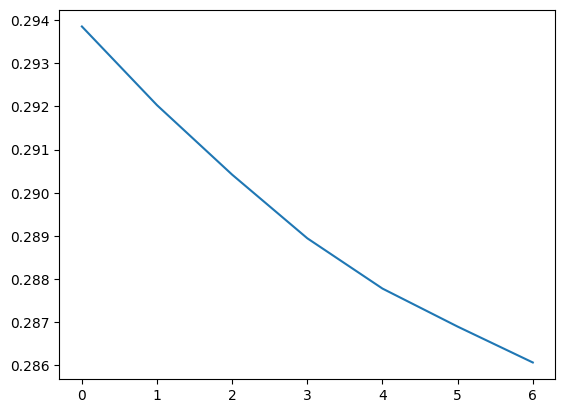

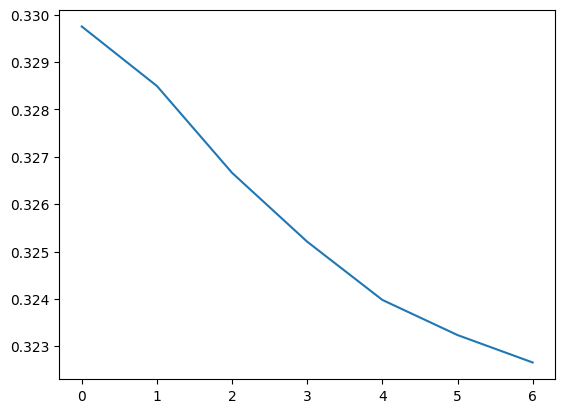

In [25]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [26]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [27]:
best_model = StockGRU()
best_model.load_state_dict(torch.load(configs["model_folder"] + "GRU.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (lstm): LSTM(
    (layer1): LSTMBlock(
      (LSTM): LSTM(10, 64, batch_first=True)
      (Dropout): Dropout(p=0.2, inplace=False)
      (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (layer2): LSTMBlock(
      (LSTM): LSTM(64, 64, batch_first=True)
      (Dropout): Dropout(p=0.2, inplace=False)
      (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (layer3): Linear(in_features=64, out_features=16, bias=True)
  )
  (month_encoder): Encoder(
    (layer1): Linear(in_features=12, out_features=32, bias=True)
    (layer2): Linear(in_features=32, out_features=8, bias=True)
  )
  (layer1): Linear(in_features=24, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=1, bias=True)
)

In [32]:
def get_log_stock_prediction(model, ticker) :
    model.eval()
    X_dataframe = data.loc[ticker].drop(columns=['target'])
    y_dataframe = data.loc[ticker]['target']

    dataset = GRUdataset(X_dataframe, y_dataframe, configs["input_size"])
    dataset.Preprocess()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=configs["batch_size"], shuffle=False)

    predict_res = []
    target_res = []
    
    for batch_X1,bacth_X2, batch_y in dataloader:
        batch_X1 = torch.transpose(batch_X1[:,:,:],1,2).to(device)
        bacth_X2 = bacth_X2[:,-1].to(device)
        batch_y = batch_y[:,None].to(device) / 25 # This is due to the model is scale by 25
        
        y_pred = model(batch_X1,bacth_X2) / 25 # This is due to the model is scale by 25

        predict_res += y_pred.to(torch.device("cpu")).reshape(-1).tolist()
        target_res += batch_y.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [33]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [34]:
def print_trade(best_model, stocks, output_frame) :
    for stock in tqdm(stocks) :
        predict,target = get_log_stock_prediction(best_model, [stock])
        buy_and_hold_profit = trade_test(np.ones(target.shape),target)
        naive_forecast_profit = trade_test(np.concatenate((np.array([0]),(target > 0)))[:-1],target)
        random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
        total_profit = trade_test(predict,target)
        inverse_total_profit = trade_test(-predict,target)
        
        new_row = {
            "Name": stock,
            "Buy_and_Hold" : buy_and_hold_profit,
            "Naive_Forecast" : naive_forecast_profit,
            "Random_Profit" : random_profit,
            "Total_Profit" : total_profit,
            "Inverse_Total_Profit" : inverse_total_profit
        }
        
        output_frame.loc[len(output_frame.index)] = new_row

In [35]:
test_filenames = data.index.unique('Ticker').to_list()
output_frame = pd.DataFrame(columns=["Name","Buy_and_Hold","Naive_Forecast","Random_Profit","Total_Profit","Inverse_Total_Profit"])
print_trade(best_model,test_filenames,output_frame)
output_frame.to_csv("./out/" + configs["model_name"] + "out.csv",index = False)

  0%|          | 0/500 [00:00<?, ?it/s]

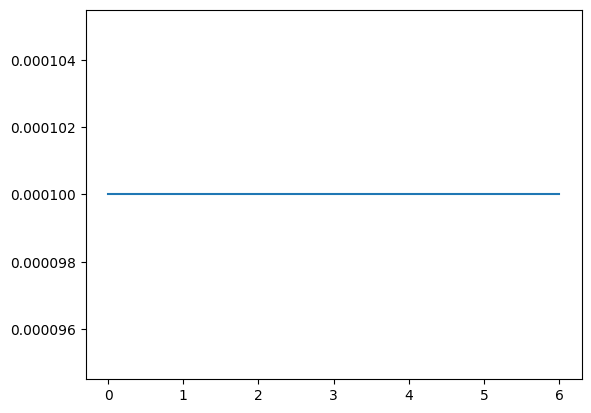

In [36]:
plt.plot(learning_rates)
plt.show()